# BLE Proximity Experiment - KNN Classifier
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [3]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [4]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
replace_features_nan(dataset)
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-47,-47.000000,0-1 meters,0.0
1,0.0,0.0,-46,-46.500000,0-1 meters,0.0
2,0.0,0.0,-46,-46.333333,0-1 meters,0.0
3,0.0,0.0,-47,-46.500000,0-1 meters,0.0
4,0.0,0.0,-47,-46.600000,0-1 meters,0.0
...,...,...,...,...,...,...
12470,0.0,3.5,-87,-84.555556,3-4 meters,3.5
12471,0.0,3.5,-87,-84.684211,3-4 meters,3.5
12472,0.0,3.5,-87,-84.800000,3-4 meters,3.5
12473,0.0,3.5,-87,-84.904762,3-4 meters,3.5


(12475, 6)

### Initialize Test Set

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,0-1 meters,0.0
1,0.0,0.0,-50,-50.000000,0-1 meters,0.0
2,0.0,0.0,-53,-51.000000,0-1 meters,0.0
3,0.0,0.0,-51,-51.000000,0-1 meters,0.0
4,0.0,0.0,-53,-53.000000,0-1 meters,0.0
...,...,...,...,...,...,...
410,0.0,3.5,-86,-83.800000,3-4 meters,3.5
411,0.0,3.5,-88,-84.500000,3-4 meters,3.5
412,0.0,3.5,-84,-84.428571,3-4 meters,3.5
413,0.0,3.5,-83,-84.250000,3-4 meters,3.5


(415, 6)

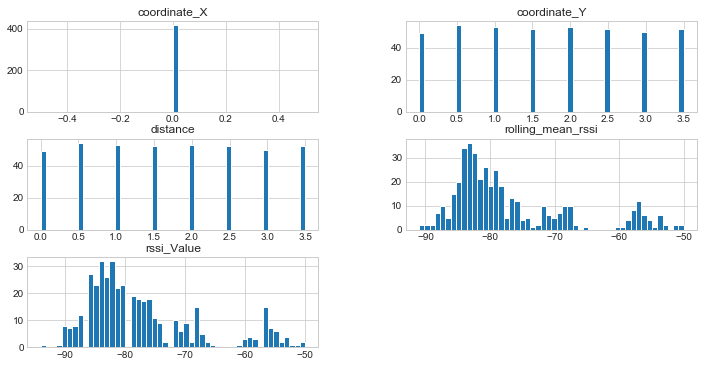

In [5]:
test_dataset = load_file('../../distance_proximity_experiments-checkpoint.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (My Device)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-44,-44.000000,0-1 meters,0.0
1,0.0,0.0,-44,-44.000000,0-1 meters,0.0
2,0.0,0.0,-44,-44.000000,0-1 meters,0.0
3,0.0,0.0,-44,-44.000000,0-1 meters,0.0
4,0.0,0.0,-45,-44.200000,0-1 meters,0.0
...,...,...,...,...,...,...
2279,0.0,3.5,-84,-83.944444,3-4 meters,3.5
2280,0.0,3.5,-85,-84.000000,3-4 meters,3.5
2281,0.0,3.5,-85,-84.050000,3-4 meters,3.5
2282,0.0,3.5,-92,-84.428571,3-4 meters,3.5


(2284, 6)

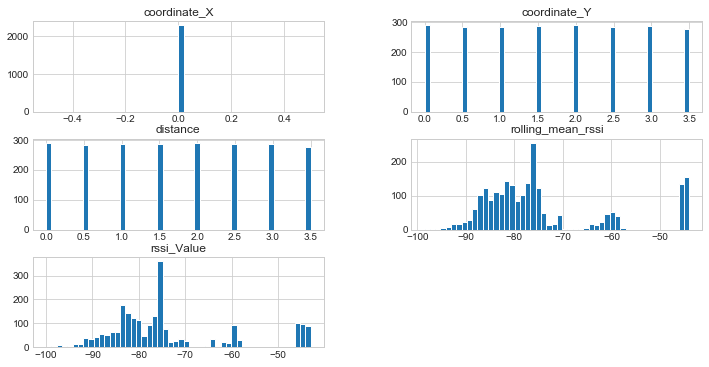

In [6]:
test_dataset_my_device = load_file('../../dataset_test.csv')
positions = test_dataset_my_device['coordinate_Y']
test_dataset_my_device['distance'] = positions
replace_features_nan(test_dataset_my_device)
display(test_dataset_my_device)
display(test_dataset_my_device.shape)
test_dataset_my_device.hist(bins=50,figsize=(12,6))
plt.show()

### Dataset Overall Info

In [7]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12475 entries, 0 to 12474
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coordinate_X       12475 non-null  float64
 1   coordinate_Y       12475 non-null  float64
 2   rssi_Value         12475 non-null  int64  
 3   rolling_mean_rssi  12475 non-null  float64
 4   zone               12475 non-null  object 
 5   distance           12475 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 584.9+ KB


None

### File Overall Description
Usage of describe pandas function on the dataset

In [8]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,12475.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0
coordinate_Y,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5
rssi_Value,12475.0,-73.416754,12.929039,-102.0,-82.0,-76.000000,-64.00,-45.0
rolling_mean_rssi,12475.0,-73.454044,12.766312,-98.5,-82.2,-76.285714,-63.75,-46.0
distance,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5


### % of Missing Values

In [9]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [10]:
compute_missing_values(dataset)

,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

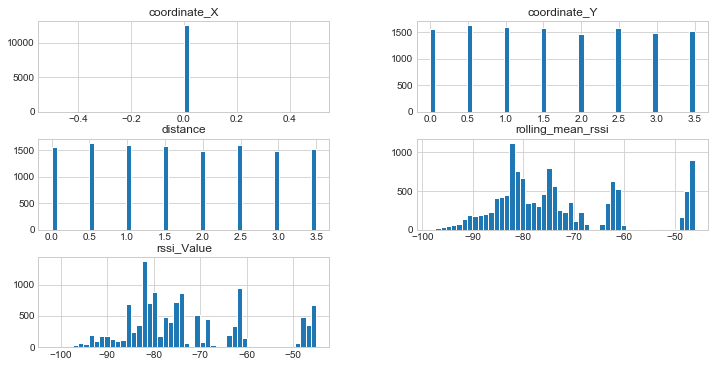

In [11]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Target Attribute - Zone
Graphical display of the zones scanned in the experiment

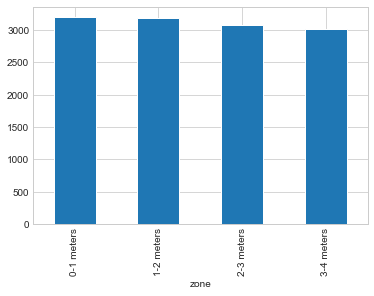

In [12]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

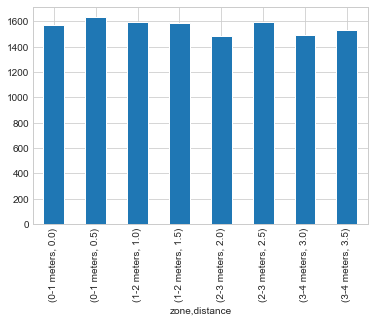

In [13]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

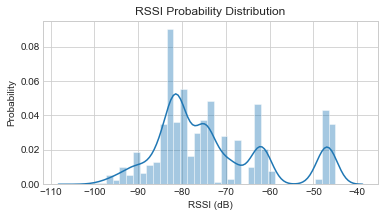

In [14]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

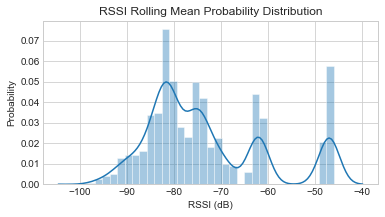

In [15]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

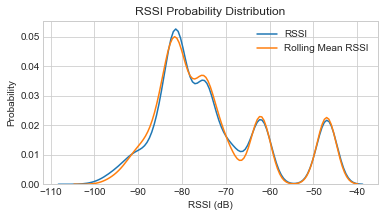

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [17]:
def compute_correlations(dataset):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix['distance'].sort_values(ascending=False))
    attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
    scatter_matrix(dataset[attributes], figsize=(12, 8))

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.864615,-0.873980,1.000000
rssi_Value,NaN,-0.864615,1.000000,0.981441,-0.864615
rolling_mean_rssi,NaN,-0.873980,0.981441,1.000000,-0.873980
distance,NaN,1.000000,-0.864615,-0.873980,1.000000


distance             1.000000
coordinate_Y         1.000000
rssi_Value          -0.864615
rolling_mean_rssi   -0.873980
coordinate_X              NaN
Name: distance, dtype: float64

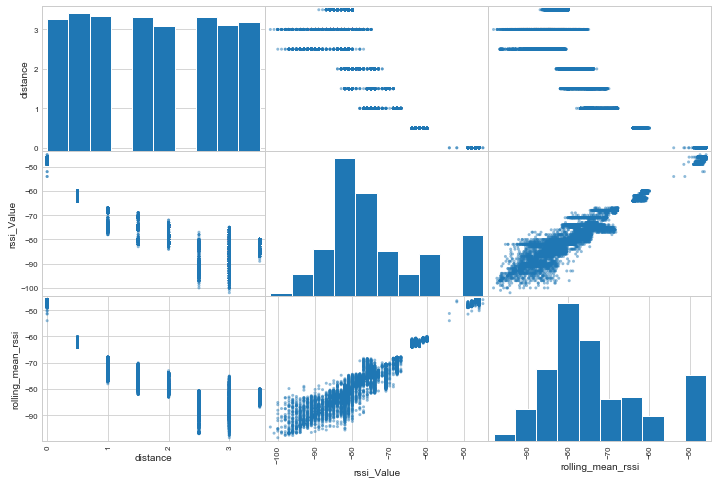

In [18]:
compute_correlations(dataset)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [19]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [20]:
compute_data_cleaning(dataset,'rssi_Value')
compute_data_cleaning(dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_my_device,'rssi_Value')
compute_data_cleaning(test_dataset_my_device,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [21]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [22]:
categorical_zone = dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
dataset['labels'] = zone_changed
train_Y = dataset['labels'].values.reshape(-1,1)
display(train_Y)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
12470,3-4 meters
12471,3-4 meters
12472,3-4 meters
12473,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0],
       [0],
       [0],
       ...,
       [3],
       [3],
       [3]])

In [23]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset['labels'] = test_changed
test_Y = test_dataset['labels'].values.reshape(-1,1)
display(test_Y.shape)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
410,3-4 meters
411,3-4 meters
412,3-4 meters
413,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(415, 1)

In [24]:
categorical_zone = test_dataset_my_device[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_my_device['labels'] = test_changed
test_Y_my_device = test_dataset_my_device['labels'].values.reshape(-1,1)
display(test_Y_my_device.shape)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
2279,3-4 meters
2280,3-4 meters
2281,3-4 meters
2282,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(2284, 1)

### Initialize Training Data
Training Data intialization for predictions purposes

In [25]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi.shape)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean.shape)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X.shape)

(12475, 1)

(12475, 1)

(12475, 2)

In [26]:
data_plot_means = dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-54.656250,-54.714171
1-2 meters,-73.941824,-73.986266
2-3 meters,-81.840872,-81.883638
3-4 meters,-84.163468,-84.165817


### Plot Training Data
Graphical Display of the observations in the dataset

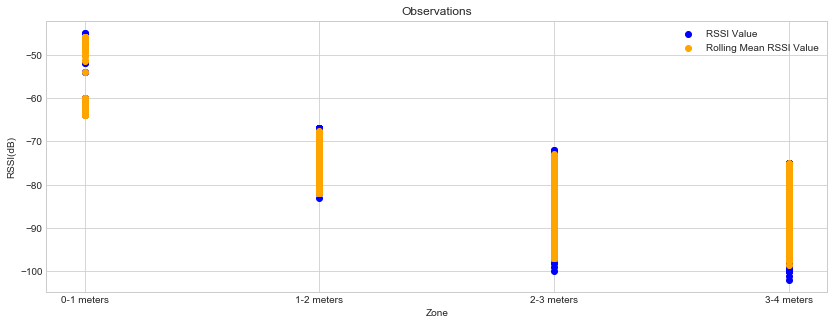

In [27]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [28]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(415, 1)

(415, 1)

(415, 2)

In [29]:
data_plot_means = test_dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-63.223301,-63.123000
1-2 meters,-79.533333,-79.841372
2-3 meters,-82.171429,-81.838530
3-4 meters,-84.215686,-83.930766


In [30]:
test_X_rssi_my_device = pd.DataFrame(test_dataset_my_device['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_my_device.shape)
test_X_rolling_mean_my_device = pd.DataFrame(test_dataset_my_device['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_my_device.shape)
test_combination_features_X_my_device = test_dataset_my_device[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_my_device.shape)

(2284, 1)

(2284, 1)

(2284, 2)

In [31]:
data_plot_means = test_dataset_my_device.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-55.246503,-55.259603
1-2 meters,-78.954545,-79.459584
2-3 meters,-77.871080,-77.982160
3-4 meters,-85.335689,-85.247963


### Plot Test Data

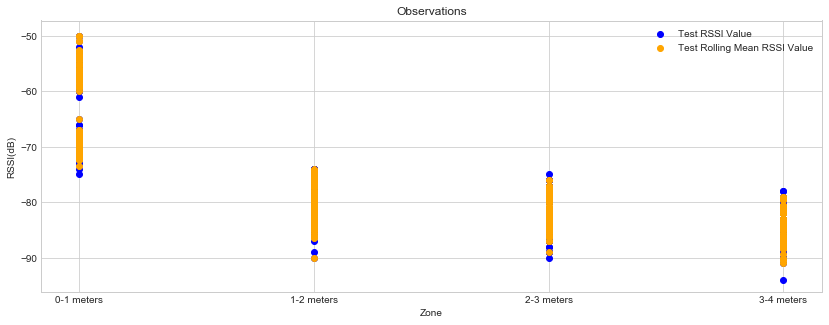

In [32]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['zone'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['zone'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

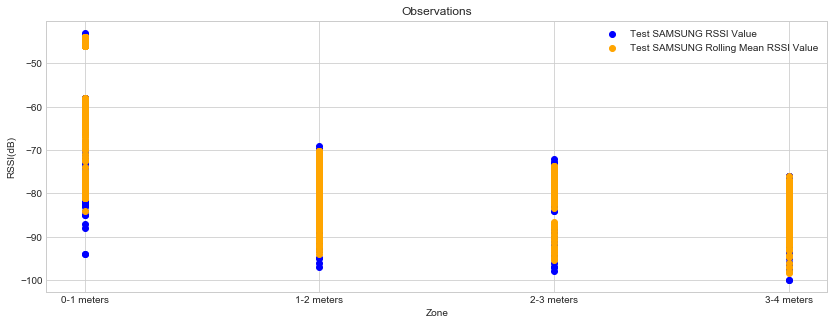

In [33]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_my_device['zone'],test_dataset_my_device['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_my_device['zone'],test_dataset_my_device['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initailize Hyperparameters for tunning

In [34]:
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
distance_metris = ["euclidean", "manhattan", "canberra", "braycurtis"]
algorithms = ["brute","kd_tree","ball_tree","auto"]
weights = ["uniform","distance"]
knn_basic = KNeighborsClassifier()
print("DEFAULT HYPERPARAMETERS")
default_params = knn_basic.get_params()
display(pd.DataFrame(default_params,index=[1])) 

DEFAULT HYPERPARAMETERS


,algorithm,leaf_size,metric,metric_params,n_jobs,n_neighbors,p,weights
1,auto,30,minkowski,None,None,5,2,uniform


### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [35]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

### Feature Selection
Check strength of features using ensemble algorithm Random Forest

Feature Selection Computation


array([0.46445963, 0.53554037])

rolling_mean_rssi    0.53554
rssi_Value           0.46446
dtype: float64

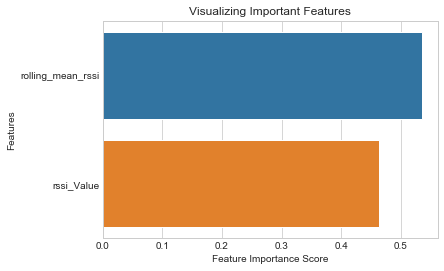

In [36]:
print("Feature Selection Computation")
random_forest_estimator = RandomForestClassifier()
main_estimator = make_pipeline(StandardScaler(),random_forest_estimator)
main_estimator.fit(combination_features_X,train_Y.ravel())
display(random_forest_estimator.feature_importances_)
feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=combination_features_X.columns).sort_values(ascending=False)
display(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Training and Evaluation - KNN Classification Model

In [37]:
def compute_KNN_with_Classifier(flag=0,trainX_data = None, trainY_data = None,testX_data = None,testY_data = None, scaler = None,
                cross_validation = None,n_neighbors=5,weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski',
                metric_params=None, n_jobs=-1):   
    knn_classifier_estimator = KNeighborsClassifier(n_neighbors,weights,algorithm,leaf_size,p,metric,metric_params,n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,knn_classifier_estimator)
    else:
        main_estimator = knn_classifier_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data) 
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    statistical_array = list()
    statistics = pd.DataFrame(report).transpose()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
    error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
    result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())


#### Check Training model with no cross validation 
Use KNN Classifier to check the results on the training data alone

Confusion Matrix:
[[3200    0    0    0]
 [   0 2301  523  356]
 [   0  589 2003  481]
 [   0  474 1148 1400]]


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.000000
1,0.684007,0.723585,0.703240,3180.000000
2,0.545182,0.651806,0.593745,3073.000000
3,0.625838,0.463269,0.532421,3022.000000
accuracy,0.713747,0.713747,0.713747,0.713747
macro avg,0.713757,0.709665,0.707351,12475.000000
weighted avg,0.716775,0.713747,0.711011,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


Confusion Matrix:
[[3200    0    0    0]
 [   0 2776  227  177]
 [   0  540 1707  826]
 [   0  119  789 2114]]


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.000000
1,0.808151,0.872956,0.839305,3180.000000
2,0.626882,0.555483,0.589027,3073.000000
3,0.678216,0.699537,0.688712,3022.000000
accuracy,0.785331,0.785331,0.785331,0.785331
macro avg,0.778312,0.781994,0.779261,12475.000000
weighted avg,0.781234,0.785331,0.782393,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


Confusion Matrix:
[[3200    0    0    0]
 [   0 2882  154  144]
 [   0  299 2400  374]
 [   0   96  573 2353]]


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.000000
1,0.879463,0.906289,0.892675,3180.000000
2,0.767509,0.780996,0.774194,3073.000000
3,0.819575,0.778623,0.798575,3022.000000
accuracy,0.868537,0.868537,0.868537,0.868537
macro avg,0.866637,0.866477,0.866361,12475.000000
weighted avg,0.868297,0.868537,0.868224,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


,mae,mse,rmse,precision,accuracy,f1-score,type
2,0.131463,0.131463,0.362578,0.867145,0.868537,0.866938,Both
1,0.214669,0.214669,0.463324,0.779732,0.785331,0.780575,Rolling Mean RSSI
0,0.286253,0.286253,0.535026,0.714187,0.713747,0.708788,RSSI Only


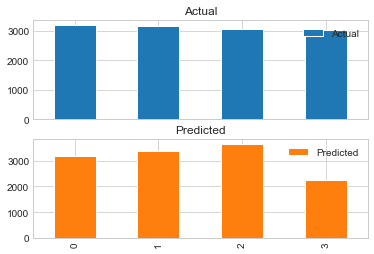

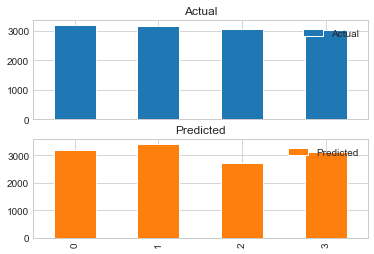

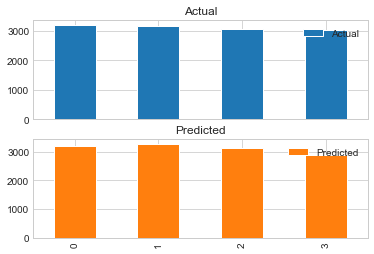

In [38]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    result = compute_KNN_with_Classifier(flag=1,trainX_data=trainX_data,trainY_data=train_Y.ravel(),
                                   testX_data=trainX_data,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

#### Experiment - KNN with StratifiedKFold 
Experiment using cross validation approach of StratifiedKFold

,mae,mse,rmse,precision,accuracy,f1-score,folds,type
11,0.215150,0.215150,0.463843,0.780903,0.784850,0.781460,5,Both
9,0.240080,0.240080,0.489980,0.754367,0.759920,0.755393,3,Both
10,0.247134,0.247134,0.497126,0.750964,0.752866,0.750495,4,Both
1,0.278477,0.278477,0.527709,0.713332,0.721523,0.708060,3,RSSI Only
3,0.294589,0.294589,0.542761,0.703460,0.705411,0.700624,5,RSSI Only
2,0.308858,0.308858,0.555750,0.686272,0.691142,0.685435,4,RSSI Only
7,0.327856,0.327856,0.572587,0.658446,0.672144,0.662327,5,Rolling Mean RSSI
6,0.337475,0.337475,0.580926,0.650782,0.662525,0.653754,4,Rolling Mean RSSI
5,0.350461,0.350461,0.591997,0.635271,0.649539,0.639552,3,Rolling Mean RSSI
8,0.368577,0.368577,0.607106,0.616276,0.631423,0.619718,2,Both


Number of Folds:  5


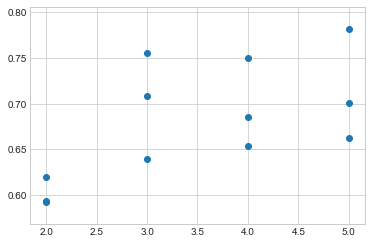

In [39]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','folds','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for cv in cross_validation_list:
        result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
        result.append(cv)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['folds'],statistics['f1-score'])
selected_fold = statistics.sort_values(by=['f1-score'],ascending=False)['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### Experiment - KNN with HoldOut (RSSI pure)
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,precision,accuracy,f1-score,test_size,type
20,0.159765,0.159765,0.399706,0.841437,0.840235,0.839406,0.3,Both
21,0.161122,0.161122,0.401400,0.839732,0.838878,0.837772,0.4,Both
24,0.160769,0.160769,0.400961,0.839305,0.839231,0.837516,0.7,Both
25,0.165832,0.165832,0.407224,0.833454,0.834168,0.832008,0.8,Both
23,0.166466,0.166466,0.408003,0.831610,0.833534,0.831683,0.6,Both
26,0.167171,0.167171,0.408866,0.832043,0.832829,0.830079,0.9,Both
19,0.167936,0.167936,0.409800,0.829709,0.832064,0.829951,0.2,Both
22,0.168804,0.168804,0.410858,0.829365,0.831196,0.829376,0.5,Both
18,0.175481,0.175481,0.418904,0.821734,0.824519,0.821803,0.1,Both
2,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,0.3,RSSI Only


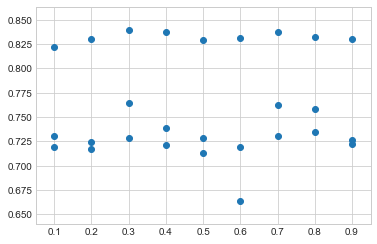

In [40]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','test_size','type']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for size in test_sizes:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = size, random_state = 42,stratify=train_Y)
        result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
        result.append(size)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['test_size'],statistics['f1-score'])

#### Experiment - KNN with Leave One Group Out (RSSI)
Experiment using cross validation approach of Leave One Group Out

In [41]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

,mae,mse,rmse,precision,accuracy,f1-score,type
0,1.0,1.0,1.0,0.0,0.0,0.0,RSSI Only
1,1.0,1.0,1.0,0.0,0.0,0.0,Rolling Mean RSSI
2,1.0,1.0,1.0,0.0,0.0,0.0,Both


#### Evaluation Model Cross-Validation Experiment - Best cross-validation technique
Best parameters found using KNN

,mae,mse,rmse,precision,accuracy,f1-score,method,type
7,0.159765,0.159765,0.399706,0.841437,0.840235,0.839406,HoldOut,Both
8,0.215150,0.215150,0.463843,0.780903,0.784850,0.781460,Stratified K-Fold,Both
1,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,HoldOut,RSSI Only
4,0.268768,0.268768,0.518429,0.727764,0.731232,0.728070,HoldOut,Rolling Mean RSSI
2,0.294589,0.294589,0.542761,0.703460,0.705411,0.700624,Stratified K-Fold,RSSI Only
5,0.327856,0.327856,0.572587,0.658446,0.672144,0.662327,Stratified K-Fold,Rolling Mean RSSI
0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,RSSI Only
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Rolling Mean RSSI
6,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Both


Selected cross validation method:  HoldOut


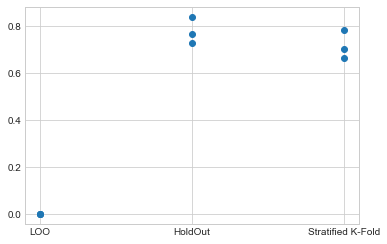

In [42]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
    holdout = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    loo = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(feature)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(feature)
    results.append(holdout)
    skfold = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold)
    skfold.append('Stratified K-Fold')
    skfold.append(feature)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['method'],statistics['f1-score'],'o')
selected_method = statistics.sort_values(by=['f1-score'],ascending=False)['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

,mae,mse,rmse,precision,accuracy,f1-score,preprocessing,preprocessingFunc,type
10,0.158429,0.158429,0.398031,0.842797,0.841571,0.840742,MaxAbsScaler,MaxAbsScaler(copy=True),Both
9,0.158429,0.158429,0.398031,0.841417,0.841571,0.840146,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Both
11,0.159498,0.159498,0.399372,0.841647,0.840502,0.839653,None,None,Both
8,0.159765,0.159765,0.399706,0.841437,0.840235,0.839406,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Both
0,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only
1,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only
2,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,MaxAbsScaler,MaxAbsScaler(copy=True),RSSI Only
3,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,None,None,RSSI Only
4,0.268768,0.268768,0.518429,0.727764,0.731232,0.728070,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
5,0.268768,0.268768,0.518429,0.727764,0.731232,0.728070,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Rolling Mean RSSI


Selected Preprocessing:  MaxAbsScaler


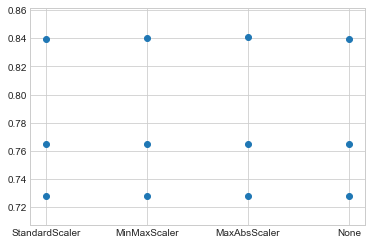

In [43]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['preprocessing'],statistics['f1-score'])
selected_preprocessing = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### Experiment -  Running the KNN function with the different weights

,mae,mse,rmse,precision,accuracy,f1-score,weights,type
4,0.159765,0.159765,0.399706,0.841437,0.840235,0.839406,uniform,Both
5,0.178199,0.178199,0.422137,0.823960,0.821801,0.820908,distance,Both
0,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,uniform,RSSI Only
1,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,distance,RSSI Only
2,0.268768,0.268768,0.518429,0.727764,0.731232,0.728070,uniform,Rolling Mean RSSI
3,0.283730,0.283730,0.532663,0.714586,0.716270,0.713717,distance,Rolling Mean RSSI


Selected weight:  uniform


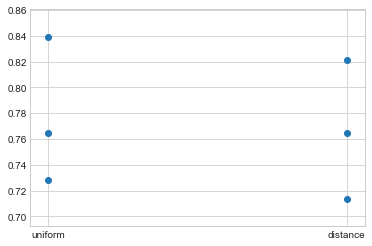

In [44]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','weights','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for weight in weights:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               weights = weight)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold,
                                weights = weight)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               weights = weight)
        result.append(weight)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['weights'],statistics['f1-score'])
selected_weight = statistics.sort_values(by=['f1-score'],ascending=False)['weights'].head(1).values[0]
print("Selected weight: ",selected_weight)

#### Experiment - Running the KNN function with the different algorithms

,mae,mse,rmse,precision,accuracy,f1-score,algorithm,type
10,0.159498,0.159498,0.399372,0.841874,0.840502,0.839686,ball_tree,Both
9,0.159765,0.159765,0.399706,0.841437,0.840235,0.839406,kd_tree,Both
11,0.159765,0.159765,0.399706,0.841437,0.840235,0.839406,auto,Both
8,0.164841,0.164841,0.406006,0.832693,0.835159,0.832987,brute,Both
1,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,kd_tree,RSSI Only
2,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,ball_tree,RSSI Only
3,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,auto,RSSI Only
0,0.227625,0.227625,0.477101,0.784624,0.772375,0.760148,brute,RSSI Only
4,0.260753,0.260753,0.510640,0.732798,0.739247,0.733932,brute,Rolling Mean RSSI
5,0.268768,0.268768,0.518429,0.727764,0.731232,0.728070,kd_tree,Rolling Mean RSSI


Selected algorithm:  ball_tree


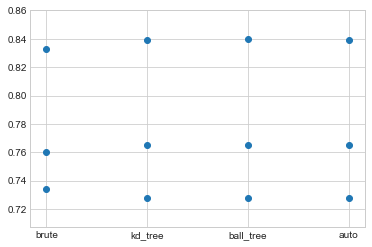

In [45]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','algorithm','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for algorithm in algorithms:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,Y_train.ravel(),groups=Y_train.ravel())
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               algorithm= algorithm)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold,
                                algorithm= algorithm)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               algorithm= algorithm)
        result.append(algorithm)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['algorithm'],statistics['f1-score'])
selected_algorithm = statistics.sort_values(by=['f1-score'],ascending=False)['algorithm'].head(1).values[0]
print("Selected algorithm: ",selected_algorithm)

#### Experiment - Running the KNN function with the different distance metrics

,mae,mse,rmse,precision,accuracy,f1-score,distance,type
10,0.158963,0.158963,0.398702,0.842552,0.841037,0.840234,canberra,Both
8,0.159765,0.159765,0.399706,0.841437,0.840235,0.839406,euclidean,Both
11,0.159765,0.159765,0.399706,0.841554,0.840235,0.839401,braycurtis,Both
9,0.160032,0.160032,0.400040,0.841199,0.839968,0.839136,manhattan,Both
0,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,euclidean,RSSI Only
1,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,manhattan,RSSI Only
2,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,canberra,RSSI Only
3,0.225488,0.225488,0.474855,0.771657,0.774512,0.764949,braycurtis,RSSI Only
4,0.268768,0.268768,0.518429,0.727764,0.731232,0.728070,euclidean,Rolling Mean RSSI
5,0.268768,0.268768,0.518429,0.727764,0.731232,0.728070,manhattan,Rolling Mean RSSI


Selected distance:  canberra


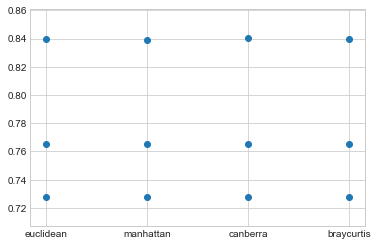

In [46]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','distance','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for distance in distance_metris:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,train_Y.ravel,groups=train_Y.ravel())
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               metric = distance)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold,
                                metric = distance)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               metric = distance)
        result.append(distance)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['distance'],statistics['f1-score'])
selected_distance = statistics.sort_values(by=['f1-score'],ascending=False)['distance'].head(1).values[0]
print("Selected distance: ",selected_distance)

#### Experiment - Tuning the K parameter

{'knn__n_neighbors': 3}
Max accuracy:  0.7111022044088177
{'knn__n_neighbors': 26}
Max accuracy:  0.679438877755511
{'knn__n_neighbors': 12}
Max accuracy:  0.7940681362725451


,n_neighbhors,type
0,3,RSSI Only
1,26,Rolling Mean RSSI
2,12,Both


Text(0, 0.5, 'Cross-validated accuracy')

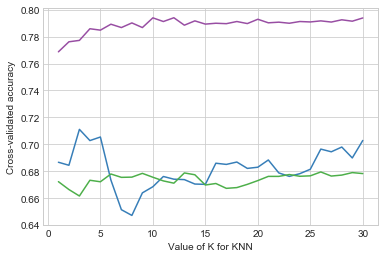

In [47]:
statistical_cols = ['n_neighbhors','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
num = 0
palette = plt.get_cmap('Set1')
grid_results = list()
k_range = list(range(1, 31))
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    result = list()
    knn_classifier_estimator = KNeighborsClassifier() #init knn regressor estimator
    param_grid = {'knn__n_neighbors': k_range}
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_classifier_estimator)])
    estimator = GridSearchCV(pipe, param_grid,cv=selected_fold)
    #fit model to data
    estimator.fit(trainX_data,train_Y.ravel())
    print(estimator.best_params_)
    grid_mean_scores = estimator.cv_results_['mean_test_score']
    print('Max accuracy: ', max(grid_mean_scores))
    grid_result = [grid_mean_scores]
    result.append(estimator.best_params_['knn__n_neighbors'])
    result.append(feature)
    results.append(result)
    grid_results.append(grid_result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
for grid in grid_results:
    num+=1
    plt.plot(k_range, grid[0],color=palette(num))
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

### Run RandomizedSearchCV for parameter tunning

In [48]:
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
num = 0
palette = plt.get_cmap('Set1')
grid_results = list()
k_range = list(range(1, 31))
tuned_parameters = {
    'knn__n_neighbors': k_range,
    'knn__metric':distance_metris,
    'knn__weights':weights,
    'knn__algorithm':algorithms
}
scores = ['f1_macro']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    for feature in types:
        #Decide on type of data
        if feature == 'RSSI Only':
            trainX_data = train_X_rssi
        elif feature == 'Rolling Mean RSSI':
            trainX_data = train_X_rolling_mean
        else:
            trainX_data = combination_features_X 
        pipe = Pipeline([('standardizer', StandardScaler()), ('knn', KNeighborsClassifier())])
        clf = RandomizedSearchCV(pipe, tuned_parameters,n_iter=75,cv=selected_fold,scoring=score,n_jobs=-1,verbose=1
        )
        clf.fit(trainX_data,train_Y.ravel())
        clf.best_params_['score'] = score
        clf.best_params_['best_score'] = clf.best_score_
        clf.best_params_['type'] = feature
        results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results).sort_values(by=['best_score'],ascending=False)
display(gridcv_results)

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   25.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   23.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   26.0s finished


,knn__weights,knn__n_neighbors,knn__metric,knn__algorithm,score,best_score,type
2,uniform,12,canberra,ball_tree,f1_macro,0.789735,Both
0,uniform,11,euclidean,brute,f1_macro,0.754553,RSSI Only
1,distance,12,canberra,brute,f1_macro,0.683033,Rolling Mean RSSI


### Best Parameters
Display the best parameters tunned throughout the experiments

In [49]:
conclusion_cols=['K Parameter','Cross Validation','Weight','Preprocessing','Algorithm','Distance']
conclusion_list = [12,selected_method,selected_weight,selected_preprocessing,selected_algorithm,selected_distance]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,K Parameter,Cross Validation,Weight,Preprocessing,Algorithm,Distance
0,12,HoldOut,uniform,MaxAbsScaler,ball_tree,canberra


### Best Results
Compute KNN with the best parameters in both RSSI and Rolling Mean

In [50]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
        result = compute_KNN_with_Classifier(n_neighbors=12,testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(n_neighbors=12,testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                             cross_validation = selected_fold,
                            algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
        result = compute_KNN_with_Classifier(n_neighbors=12,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                             scaler=StandardScaler(),algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

,mae,mse,rmse,precision,accuracy,f1-score,type
2,0.159498,0.159498,0.399372,0.841493,0.840502,0.838945,Both
0,0.220144,0.220144,0.469195,0.776686,0.779856,0.776539,RSSI Only
1,0.252471,0.252471,0.502465,0.741230,0.747529,0.742616,Rolling Mean RSSI


### Best Results - Testing data (using data recovered from Android 6.0 Asus ZENFONE Live)
Experiment with testing dataset

Confusion Matrix:
[[50 52  1  0]
 [ 0 28 54 23]
 [ 0 17 61 27]
 [ 0  0 74 28]]


,precision,recall,f1-score,support
0,1.000000,0.485437,0.653595,103.00000
1,0.288660,0.266667,0.277228,105.00000
2,0.321053,0.580952,0.413559,105.00000
3,0.358974,0.274510,0.311111,102.00000
accuracy,0.402410,0.402410,0.402410,0.40241
macro avg,0.492172,0.401891,0.413873,415.00000
weighted avg,0.490687,0.402410,0.413461,415.00000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,3,3
411,3,3
412,3,2
413,3,2


Confusion Matrix:
[[  0   0   0 103]
 [  0   0   0 105]
 [  0   0   0 105]
 [  0   0   0 102]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,103.000000
1,0.000000,0.000000,0.000000,105.000000
2,0.000000,0.000000,0.000000,105.000000
3,0.245783,1.000000,0.394584,102.000000
accuracy,0.245783,0.245783,0.245783,0.245783
macro avg,0.061446,0.250000,0.098646,415.000000
weighted avg,0.060409,0.245783,0.096982,415.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


Confusion Matrix:
[[50 53  0  0]
 [ 0 34 49 22]
 [ 0 14 51 40]
 [ 0  1 47 54]]


,precision,recall,f1-score,support
0,1.000000,0.485437,0.653595,103.000000
1,0.333333,0.323810,0.328502,105.000000
2,0.346939,0.485714,0.404762,105.000000
3,0.465517,0.529412,0.495413,102.000000
accuracy,0.455422,0.455422,0.455422,0.455422
macro avg,0.536447,0.456093,0.470568,415.000000
weighted avg,0.534726,0.455422,0.469506,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


Confusion Matrix:
[[  0   0   0 103]
 [  0   0   0 105]
 [  0   0   0 105]
 [  0   0   0 102]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,103.000000
1,0.000000,0.000000,0.000000,105.000000
2,0.000000,0.000000,0.000000,105.000000
3,0.245783,1.000000,0.394584,102.000000
accuracy,0.245783,0.245783,0.245783,0.245783
macro avg,0.061446,0.250000,0.098646,415.000000
weighted avg,0.060409,0.245783,0.096982,415.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


Confusion Matrix:
[[50 53  0  0]
 [ 0 27 27 51]
 [ 0  5 36 64]
 [ 0  2 32 68]]


,precision,recall,f1-score,support
0,1.000000,0.485437,0.653595,103.000000
1,0.310345,0.257143,0.281250,105.000000
2,0.378947,0.342857,0.360000,105.000000
3,0.371585,0.666667,0.477193,102.000000
accuracy,0.436145,0.436145,0.436145,0.436145
macro avg,0.515219,0.438026,0.443009,415.000000
weighted avg,0.513921,0.436145,0.441747,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


Confusion Matrix:
[[  0   0   0 103]
 [  0   0   0 105]
 [  0   0   0 105]
 [  0   0   0 102]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,103.000000
1,0.000000,0.000000,0.000000,105.000000
2,0.000000,0.000000,0.000000,105.000000
3,0.245783,1.000000,0.394584,102.000000
accuracy,0.245783,0.245783,0.245783,0.245783
macro avg,0.061446,0.250000,0.098646,415.000000
weighted avg,0.060409,0.245783,0.096982,415.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


,mae,mse,rmse,precision,accuracy,f1-score,type,Tuning
2,0.544578,0.544578,0.737955,0.524626,0.455422,0.468253,Rolling Mean RSSI,True
4,0.563855,0.563855,0.750903,0.503737,0.436145,0.441848,Both,True
0,0.597590,0.597590,0.773040,0.479136,0.402410,0.412177,RSSI Only,True
1,0.754217,0.754217,0.868457,0.087632,0.245783,0.119428,RSSI Only,False
3,0.754217,0.754217,0.868457,0.087632,0.245783,0.119428,Rolling Mean RSSI,False
5,0.754217,0.754217,0.868457,0.087632,0.245783,0.119428,Both,False


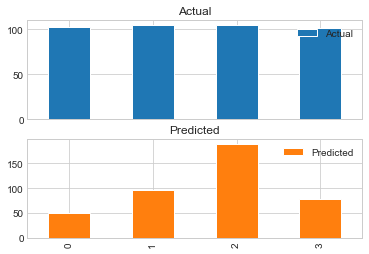

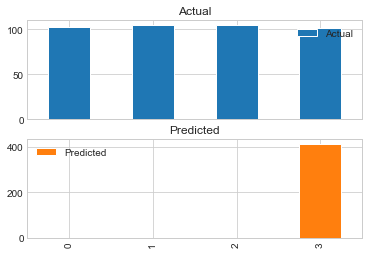

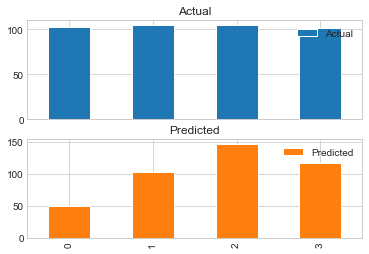

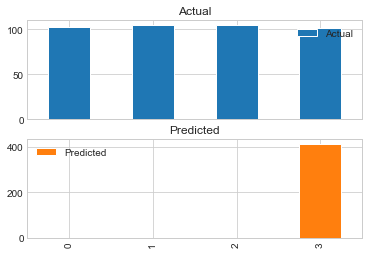

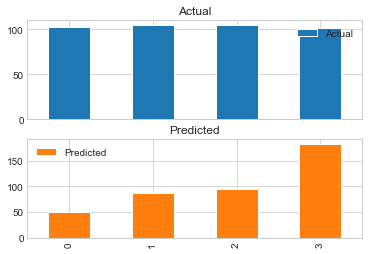

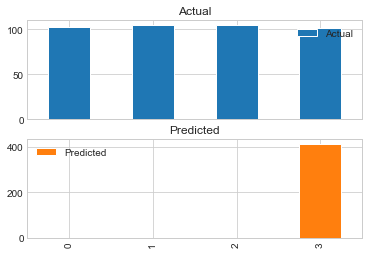

In [51]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X 
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = KNeighborsClassifier(n_neighbors=12,algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
        else: 
            model = KNeighborsClassifier()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y.ravel(), predicted)
        report = classification_report(test_Y.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

### Best Results - Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71)
Experiment with testing dataset

Confusion Matrix:
[[490  42  30  10]
 [  0 214 242 116]
 [  0 344 202  28]
 [  0   7 339 220]]


,precision,recall,f1-score,support
0,1.000000,0.856643,0.922787,572.000000
1,0.352554,0.374126,0.363020,572.000000
2,0.248462,0.351916,0.291276,574.000000
3,0.588235,0.388693,0.468085,566.000000
accuracy,0.492995,0.492995,0.492995,0.492995
macro avg,0.547313,0.492845,0.511292,2284.000000
weighted avg,0.546944,0.492995,0.511213,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,3,2
2280,3,2
2281,3,2
2282,3,2


Confusion Matrix:
[[  0   0   0 572]
 [  0   0   0 572]
 [  0   0   0 574]
 [  0   0   0 566]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,572.000000
1,0.000000,0.000000,0.000000,572.000000
2,0.000000,0.000000,0.000000,574.000000
3,0.247811,1.000000,0.397193,566.000000
accuracy,0.247811,0.247811,0.247811,0.247811
macro avg,0.061953,0.250000,0.099298,2284.000000
weighted avg,0.061410,0.247811,0.098429,2284.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,3


Confusion Matrix:
[[486  46  26  14]
 [  0 219 175 178]
 [  0 341 146  87]
 [  0   8 216 342]]


,precision,recall,f1-score,support
0,1.000000,0.849650,0.918715,572.000000
1,0.356678,0.382867,0.369309,572.000000
2,0.259325,0.254355,0.256816,574.000000
3,0.550725,0.604240,0.576243,566.000000
accuracy,0.522329,0.522329,0.522329,0.522329
macro avg,0.541682,0.522778,0.530270,2284.000000
weighted avg,0.541411,0.522329,0.529910,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,3,3
2280,3,2
2281,3,3
2282,3,3


Confusion Matrix:
[[  0   0   0 572]
 [  0   0   0 572]
 [  0   0   0 574]
 [  0   0   0 566]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,572.000000
1,0.000000,0.000000,0.000000,572.000000
2,0.000000,0.000000,0.000000,574.000000
3,0.247811,1.000000,0.397193,566.000000
accuracy,0.247811,0.247811,0.247811,0.247811
macro avg,0.061953,0.250000,0.099298,2284.000000
weighted avg,0.061410,0.247811,0.098429,2284.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,3


Confusion Matrix:
[[487  47  18  20]
 [  0 193 147 232]
 [  0 309 115 150]
 [  0   4 201 361]]


,precision,recall,f1-score,support
0,1.000000,0.851399,0.919736,572.00000
1,0.349005,0.337413,0.343111,572.00000
2,0.239085,0.200348,0.218009,574.00000
3,0.473132,0.637809,0.543266,566.00000
accuracy,0.506130,0.506130,0.506130,0.50613
macro avg,0.515306,0.506742,0.506030,2284.00000
weighted avg,0.515175,0.506130,0.505680,2284.00000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,2


Confusion Matrix:
[[  0   0   0 572]
 [  0   0   0 572]
 [  0   0   0 574]
 [  0   0   0 566]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,572.000000
1,0.000000,0.000000,0.000000,572.000000
2,0.000000,0.000000,0.000000,574.000000
3,0.247811,1.000000,0.397193,566.000000
accuracy,0.247811,0.247811,0.247811,0.247811
macro avg,0.061953,0.250000,0.099298,2284.000000
weighted avg,0.061410,0.247811,0.098429,2284.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,3


,mae,mse,rmse,precision,accuracy,f1-score,type,Tuning
2,0.477671,0.477671,0.691137,0.538878,0.522329,0.529085,Rolling Mean RSSI,True
0,0.507005,0.507005,0.712043,0.539500,0.492995,0.508667,RSSI Only,True
4,0.493870,0.493870,0.702759,0.513976,0.506130,0.505995,Both,True
1,0.752189,0.752189,0.867288,0.088426,0.247811,0.120390,RSSI Only,False
3,0.752189,0.752189,0.867288,0.088426,0.247811,0.120390,Rolling Mean RSSI,False
5,0.752189,0.752189,0.867288,0.088426,0.247811,0.120390,Both,False


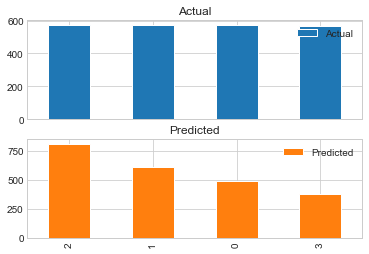

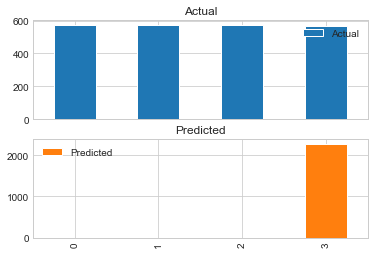

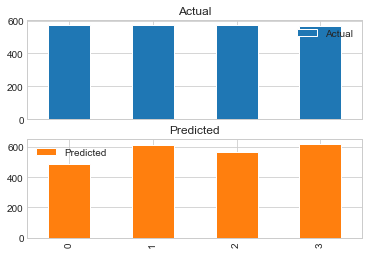

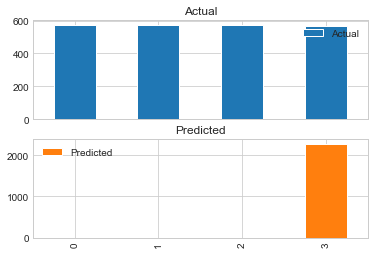

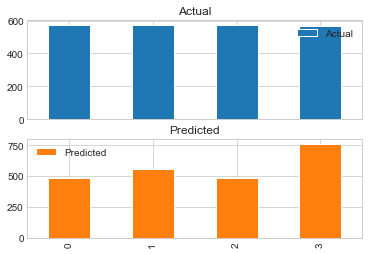

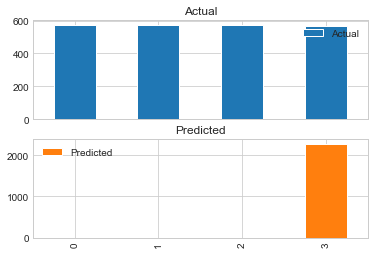

In [52]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_my_device
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_my_device
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_my_device
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = KNeighborsClassifier(n_neighbors=12,algorithm=selected_algorithm,metric=selected_distance,
                             weights=selected_weight)  
        else: 
            model = KNeighborsClassifier()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y_my_device.ravel(), predicted)
        report = classification_report(test_Y_my_device.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_my_device.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_my_device.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))